# Open Problems - Multimodal Single-Cell Integration

## Setup

In [1]:
import sys

sys.path.append("../working")

In [2]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [3]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from src.get_score import get_score
from src.load_data import InputData
from src.make_dataset import BaseDataset, get_transforms
from src.make_model import ImageBaseModel
from src.utils import df_stats
from torch.utils.data import DataLoader

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

2022-08-24 22:11:16,844 [INFO] [utils] Note: detected 88 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2022-08-24 22:11:16,846 [INFO] [utils] Note: NumExpr detected 88 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-24 22:11:16,846 [INFO] [utils] NumExpr defaulting to 8 threads.


In [4]:
# Competition specific library

## 目的

このコンペティションの目的は、骨髄幹細胞がより成熟した血液細胞へと成長する過程で、DNA、RNA、タンパク質の測定値が単一細胞内でどのように共変動するかを予測することである。このコンペティションのために、細胞中心の創薬企業であるCellarity社が作成した、4人のヒトドナーのCD34+造血幹・前駆細胞（HSPC）の5時点の30万細胞の時間経過データセットのサブセットを用いて、トレーニングしたモデルを開発することになります。

テストセットでは、データセット内の未知の遅い時点から取得され、競技者は1つのモダリティを与えられ、同じセルで測定された対のモダリティを予測することを課される。このコンペティションの課題は、テストデータがトレーニングデータのどの時点のものよりも遅い時点のものであることである。

あなたの研究は、細胞の状態を何層にも分けて遺伝情報をマッピングする方法の技術革新を加速させるでしょう。もし、ある様式を別の様式から予測することができれば、これらの複雑な制御過程を支配する規則についての理解を深めることができるかもしれません。

![predict](https://user-images.githubusercontent.com/1638500/186604146-0dfcb9b7-87a3-466c-b2a5-e297b93cef87.png)

過去10年間、シングルセルゲノミクスの登場により、単一細胞内のDNA、RNA、タンパク質の測定が可能になった。これらの技術により、前例のないスケールと解像度で生物学を研究することが可能になった。その結果、ヒトの初期胚発生の詳細なマップ、新しい疾患関連細胞の発見、細胞を標的とした治療介入などが実現しました。さらに、最近の実験技術の進歩により、同一細胞内の複数のゲノムモダリティを測定することが可能になった。

マルチモーダルなシングルセルデータがますます利用できるようになる一方で、データ解析手法はまだ不足しています。単一細胞は体積が小さいため、測定値はまばらでノイズが多い。細胞間の分子サンプリング深さの違い（シーケンシング深さ）や、バッチで細胞を扱うことによる技術的効果（バッチ効果）は、しばしば生物学的な差異を圧倒することがあります。マルチモーダルデータを解析する場合、異なる特徴空間、モダリティ間およびバッチ間の共有および固有の変動を考慮する必要があります。さらに、現在の単一細胞データ解析のパイプラインは、たとえその下にダイナミックな生物学的プロセスがあったとしても、細胞を静的なスナップショットとして扱っている。時間経過に伴う状態の変化と同時に時間的なダイナミクスを考慮することは、シングルセルデータサイエンスにおける未解決の課題である。

一般に、遺伝情報はDNA→RNA→タンパク質と流れる。RNA（GEXデータ）を生成するためにはDNAにアクセスできなければならず（ATACデータ）、RNAはタンパク質を生成するための鋳型として利用される（ADTデータ）。これらのプロセスは、フィードバックによって制御されています。例えば、タンパク質がDNAと結合することで、より多くのRNAが生成されるのを防ぐことができます。このような遺伝子の制御が、生物が発展し、環境の変化に適応していくためのダイナミックな細胞プロセスの基盤となっているのです。単一細胞データ科学では、動的プロセスは、生物学的プロセスの進行を捕らえる、いわゆる擬似時間アルゴリズムによってモデル化されてきた。しかし、これらのアルゴリズムを一般化し、擬似時間と実時間の両方を考慮することは、まだ未解決の問題である。

コンペティション主催のOpen Problems in Single-Cell Analysisは、シングルセル解析手法のベンチマークを標準化するための、オープンソースかつコミュニティ主導の取り組みです。Open Problemsの中核となる取り組みには、既存の課題を測定可能なタスクに形式化すること、高品質のデータセットを収集すること、コミュニティから提供された手法のベンチマークを集中的に行うこと、多様な手法開発者を集めてシングルセルのアルゴリズムを改善するコミュニティに焦点を当てたイベントを開催することなどがあります。彼らは、Cellarity、Chan Zuckerbeg Biohub、Chan Zuckerberg Initiative、Helmholtz Munich、Yaleと提携し、学際的なコラボレーションを通じて、遺伝的ダイナミックスの時間的変化を予測することにどんな進展が見られるかに期待しています。

人体には約37兆個の細胞が存在し、それぞれが異なる行動や機能を有しています。一つのゲノムがどのようにして多様な細胞状態を生み出すのかを理解することは、健康や病気において組織がどのように機能し、どのように誤作動を起こすのかをメカニズム的に理解するための鍵となります。あなたは、この単一細胞生物学の基本的な課題の解決に貢献することができます。予測問題を長期にわたって解くことができれば、血液や免疫細胞の成熟に伴う分化に遺伝子制御がどのように影響するかについて、新たな知見を得ることができるかもしれません。


## 評価

投稿の順位付けには、ピアソン相関係数を使用しています。Multiomeデータセットの各オブザベーションについて、グランドトゥルース遺伝子発現と予測される遺伝子発現の相関を計算します。CITEseqデータセットの各オブザベーションについて、ground-truthの表面タンパク質レベルと予測される表面タンパク質レベルの間の相関を計算します。総合スコアは、各サンプルの相関スコアの平均値です。あるサンプルの予測値がすべて同じであった場合、そのサンプルの相関は-1.0としてスコア化されます。


## 提出ファイル

評価セット内の各idについて、そのrow_idの ターゲット値を予測する必要があります。提出物はヘッダーを含み、以下のフォーマットである必要があります。



```
row_id,target
0,0.0
1,0.0
2,0.0
3,0.0
...
```

提出ファイルは、テストセットのオブザベーションのサブセットのみを含む必要があります。含まれるべき特定の ID については、データ説明を参照してください。




## データ

このコンペティションのデータセットは、4人の健康なヒトドナーから分離した動員末梢CD34+造血幹細胞および前駆細胞（HSPCs）から収集したシングルセルマルチオミクスデータから構成されています。細胞の詳細については、ベンダーのウェブサイトをご覧ください。

測定は10日間にわたり、5つの時点で行われた。各時点の各プレートから、2種類のシングルセルアッセイで測定するために細胞を採取した。1つ目は10x Chromium Single Cell Multiome ATAC + Gene Expressiontechnology（Multiome）、2つ目は10x Genomics Single Cell Gene Expression with Feature Barcodingtechnologyで、TotalSeq™-B Human Universal Cocktail, V1.0(CITEseq) を使用したもの。

このデータ型を扱ったことがない方は、この説明の一番下にいくつかのリンクを載せています。

各アッセイ技術では、2つのモダリティを測定します。Multiomeキットはクロマチンアクセシビリティ（DNA）と遺伝子発現（RNA）を、CITEseqキットは遺伝子発現（RNA）と表面タンパク質のレベルを測定します。

分子生物学のセントラルドグマに従うとDNA→RNA→タンパク質という分子生物学のセントラルドグマに従って、あなたの仕事は次の通りです。

- Multiomeサンプルの場合：クロマチンアクセシビリティが与えられた場合、遺伝子発現を予測する。
- CITEseqサンプルについて：遺伝子発現が与えられた場合、タンパク質量を予測する。

### 細胞の種類

解析の参考のため、以下の論文の情報を用いて、RNA 遺伝子発現に基づく予備的な細胞タイプアノテーションを行った： https://www.nature.com/articles/ncb3493 .細胞タイプのアノテーションは不正確な技術であり、連続データに離散的なラベルを割り当てるという概念には固有の限界があることに注意してください。これらのラベルを予測に使用する必要はなく、主に探索的な解析のガイドとして提供されている。このデータでは、以下のような細胞タイプがある。

- MasP= マスト細胞プロジェニター
- MkP＝メガカリョク細胞プロジェニター
- NeuP= 好中球プロジェニター
- MoP= Monocyte Progenitor（単球前駆体）。
- EryP= 赤血球前駆体（Erythrocyte Progenitor）。
- HSC= Hematoploetic Stem Cell（造血幹細胞）。
- BP= B細胞プロジェニター


### ファイルおよびフィールドの説明

- metadata.csv
    - cell_id- 観測された各セルに対する一意の識別子．
    - donor- 4人の細胞ドナーの識別子。
    - day- 観察が行われた実験の日。
    - 技術-citeseqか multiomeのどちらか。
    - cell_type- 上記のセルタイプの1つ，あるいは非表示．

実験観測はいくつかの大きなアレイに含まれています。これらのアレイはHDF5フォーマットで提供されます。


#### マルチオーム

- `train/test_multi_inputs.h5`- ATAC-seq peak counts をTF-IDFで変換し、デフォルトのlog(TF) * log(IDF)output (chromatin accessibility)を使用。行は細胞、列はアクセスレベルを測定したゲノムの位置（ここでは 10xReferences - 2020-A (July 7, 2020) で提供された参照ゲノム GRCh38 のゲノム座標により特定）に相当します。
- `train_multi_targets.h5`- RNA遺伝子発現レベル（同一細胞のライブラリサイズ正規化およびlog1p変換カウントとして）。


#### CITEseq

- `train/test_cite_inputs.h5`- RNAライブラリサイズで正規化、log1p変換したカウント値（遺伝子発現レベル）、行は{gene_name}_{gene_ensemble-ids}で指定したセル、列は遺伝子に対応。
- `train_cite_targets.h5`-dsbで正規化された同じ細胞の表面タンパク質レベル。


#### データ分割

データ分割は以下のように整理されている。

- トレーニングセットは、13176、31800、32606のドナーからのサンプルだけから構成される。公開テストセットは、ドナー27678からのサンプルだけから構成される。プライベートテストセットは、4人のドナーすべてからのサンプルで構成される。
- Multiomeサンプルについては、トレーニングセットは2日目、3日目、4日目、7日目のサンプルのみで構成されています。公開テストセットは、2日目、3日目、7日目のデータのみから構成される。プライベートテストセットは、10日目のデータのみから構成される。
- CITEseqサンプルについては、トレーニングセットは2日目、3日目、4日目のサンプルのみから構成されています。公開テストセットも2日目、3日目、4日目のみのサンプルから構成される。プライベートテストセットは、7日目のサンプルだけから構成されます。どの分割においても、10日目のCITEseqサンプルは存在しない。

![data-split](https://user-images.githubusercontent.com/1638500/186604139-c3269f74-9b8c-4521-80f2-7930b6e607cb.jpg)


あなたの課題は、テストセットの入力に対応するラベルを予測することです。提出物の採点を容易にするため、マルチオームデータのサブセットに対する予測のみを要求します。このサブセットは、Multiomeの行の30%、各行に対して列の15%をサンプリングして作成されています。列のサンプルは行ごとに異なります。CITEseqラベルは全てスコア化されています。

- `evaluation_ids.csv`- 評価対象のテストセットからラベルを特定する。ラベルマトリックスのcell_id/gene_id識別子から、提出ファイルに必要なrow_idへの結合キーが提供されます。
- `sample_submission.csv`- 正しい形式の投稿ファイルのサンプルです。詳しくは、評価のページをご覧ください。

### 学習リソース

- Open Problems - マルチモーダル単一細胞データについて- マルチモーダルデータを初めて見る人に説明するために昨年作成した情報ページです。
  https://openproblems.bio/neurips_docs/data/about_multimodal/
- モデル、推論、アルゴリズム - マルチモーダル単一細胞解析で競争するために団結する- コンペティションの背景と動機を提供するBroad Institutes Models, Inferences, and Algorithmsセミナーでコンペティション主催者によって発表された講演です。


## Discussion メモ



### Welcome to the Open Problems Multimodal Single-Cell Integration challenge!

https://www.kaggle.com/competitions/open-problems-multimodal/discussion/344607

このコンペティションは、単一細胞で同時に測定された異なる遺伝子測定値（DNA、RNA、タンパク質）間の関係を予測することをテーマとしています。生物医学の分野では、シングルセル技術によって、人体に存在する37兆個の細胞の多様性や、これらの細胞の種類が健康と病気の間でどのように異なるかについて、爆発的に新しい知見が得られてきています。しかし、この分野にはまだいくつかの壮大な課題が残されており、細胞状態のダイナミクスのモデリングは最大の未解決問題の一つである（Genome Biology 2020）。

このコンペティションでOpen Problemsは、細胞中心の創薬企業であるCellarity社と提携し、細胞の状態変化を時系列で捉えることができるアルゴリズムの進歩を促すために設計された、世界初のベンチマークデータセットを作成しました。我々は、2つの異なるマルチモーダル単一細胞技術を用いて、4人の健康なヒトドナーのCD34+造血幹細胞および前駆細胞（HSPCs）を5つの時点で測定しました。あなたの課題は、これらのモダリティ間の関係を学び、データセット内の後の未知の時点において、一方から他方へ予測する方法を学ぶことです。





### Understanding the Competition + Some Domain Knowledge

https://www.kaggle.com/competitions/open-problems-multimodal/discussion/346888

- このコンペティションは2つのパートに分かれていると考えることができます。MultiomeとCITEseqです。
- どちらのパートでも、ベクトル入力が与えられたときにベクトル予測を行うモデルが必要です。
- 各セルIDはサンプルを表します。
- Multiomeでは、変換された数値DNAデータを使って、変換された数値RNAデータを予測する必要があります。
- CITEseqでは、変換された数値RNAデータを用いて、変換された数値Proteinデータを予測する必要があります。

<img alt="inbox_6537187_bf8c54a125ecfd986cd30c5ecc0724a2_central_dogma2" src="https://user-images.githubusercontent.com/1638500/186604158-3123609f-bd97-46d5-8193-f9a4012bb8c9.png">


- 予測値をターゲットテーブルと同様にフォーマットする
- ラベルマトリックスからcell_id / gene_id のインデックスを作成し、evalations_ids.csv を作成する。
- evaulations_ids.csvをsample_submission.csvにrow_idでマッピングする。

<img alt="inbox_6537187_1997e2ec55923d44b4d0a53221311456_sub_pic" src="https://user-images.githubusercontent.com/1638500/186604154-ba0643d6-5c00-445c-9d2f-28170f000c6e.png">




### セントラルドグマ

https://ja.wikipedia.org/wiki/%E3%82%BB%E3%83%B3%E3%83%88%E3%83%A9%E3%83%AB%E3%83%89%E3%82%B0%E3%83%9E

セントラルドグマ（英: central dogma）とは、遺伝情報は「DNA→（転写）→mRNA→（翻訳）→タンパク質」の順に伝達される、という、分子生物学の概念である。

![220px-Central_Dogma_of_Molecular_Biochemistry_with_Enzymes](https://user-images.githubusercontent.com/1638500/186604150-9b557a15-c668-4891-8d02-09bbe64137ea.jpg)

セントラルドグマの流れ。DNAポリメラーゼによって複製されたDNAは、RNAポリメラーゼによって転写されてRNA (mRNA) が合成され、転写されたRNAはリボソームに結合して翻訳され、たんぱく質が合成される


#### 遺伝情報の発現

真核生物におけるセントラルドグマの過程は次のとおりである。まず、RNAポリメラーゼIIの働きにより、DNAの遺伝情報はmRNAに転写される。次に、mRNAが核膜の孔を通って核から細胞質基質に出ると、細胞質基質中のリボソームに結合する。リボソームにおいては、アミノ酸を運んできたtRNAが、mRNAの3つずつの塩基配列（コドン）に対応して結合し、運ばれてきたアミノ酸が繋がってペプチドを作る。RNAからタンパク質を作ることを翻訳と呼ぶ。この、DNAからタンパク質が出来る流れの概念がセントラルドグマである。

通常、遺伝情報はこのようにDNAからタンパク質に一方的に伝達され発現するのであるが、例外がある。RNAを遺伝子としているウイルスの一部（レトロウイルス）は、宿主細胞内でRNAをDNAに変換するセントラルドグマの逆反応を行う。その後に、セントラルドグマに従ってDNAからRNAの転写を経てタンパク質へ翻訳され、ウイルスが作成される。

#### 遺伝情報の複製

生物の遺伝情報はゲノムDNAに保存されている。生物の基本単位である細胞が同じ遺伝情報を持った二つの細胞に分裂するためには、細胞が分裂する前に親細胞と同じ遺伝情報をもう一揃え合成する必要がある。この遺伝情報の複製はDNA複製によって行われる。また親から子への遺伝もDNA複製によって行なわれるが、有性生殖を行う生物は減数分裂によって染色体の選択が行われた接合子が接合する事で両親の遺伝情報の半分ずつを受け継ぐ。

複製は 極めて高い精度で行われるが、それでも10e-9程度の割合で合成ミスが起こる。また紫外線や放射線、化学物質によってDNAが傷つき、突然変異が生じることもある。





## EDA メモ

- すべてのデータの読み込みに 40分 ほど必要  
  ![data-loading-time](https://user-images.githubusercontent.com/1638500/186604130-2c1004be-e8ed-4042-9663-123dd641a80b.png)





In [5]:
c = OmegaConf.load("../working/config/main.yaml")

input = InputData(c, use_fold=True, do_preprocess=True)

2022-08-24 22:11:19,322 [INFO] [load_data] Load feather file. path: ../input/evaluation_ids.f
2022-08-24 22:11:26,123 [INFO] [utils] Mem. usage decreased to 125Mb: 16% reduction
2022-08-24 22:11:26,472 [INFO] [load_data] Load feather file. path: ../input/metadata.f
2022-08-24 22:11:26,592 [INFO] [utils] Mem. usage decreased to 7.2Mb: 32% reduction
2022-08-24 22:11:26,597 [INFO] [load_data] Load feather file. path: ../input/sample_submission.f
2022-08-24 22:11:28,929 [INFO] [utils] Mem. usage decreased to 501Mb: 49% reduction
2022-08-24 22:11:28,932 [INFO] [load_data] Load original file. path: ../input/test_cite_inputs.h5
2022-08-24 22:12:33,493 [INFO] [utils] Mem. usage decreased to 409Mb: 0.% reduction
2022-08-24 22:12:33,545 [INFO] [load_data] Load original file. path: ../input/test_multi_inputs.h5
2022-08-24 22:24:41,921 [INFO] [utils] Mem. usage decreased to 488Mb: 0.% reduction
2022-08-24 22:24:42,649 [INFO] [load_data] Load original file. path: ../input/train_cite_inputs.h5
2022-

## Metadata



In [7]:
input.metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281528 entries, 0 to 281527
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   cell_id     281528 non-null  object
 1   day         281528 non-null  int8  
 2   donor       281528 non-null  int16 
 3   cell_type   281528 non-null  object
 4   technology  281528 non-null  object
dtypes: int16(1), int8(1), object(3)
memory usage: 7.2+ MB


In [8]:
input.metadata.head()

,cell_id,day,donor,cell_type,technology
0,c2150f55becb,2,27678,HSC,citeseq
1,65b7edf8a4da,2,27678,HSC,citeseq
2,c1b26cb1057b,2,27678,EryP,citeseq
3,917168fa6f83,2,27678,NeuP,citeseq
4,2b29feeca86d,2,27678,EryP,citeseq


In [9]:
input.metadata.tail()

,cell_id,day,donor,cell_type,technology
281523,96a60b026659,10,31800,hidden,multiome
281524,d493e546991e,10,31800,hidden,multiome
281525,05666c99aa48,10,31800,hidden,multiome
281526,121f946642b5,10,31800,hidden,multiome
281527,b847ba21f59f,10,31800,hidden,multiome


In [10]:
input.metadata.describe()

,day,donor
count,281528.000000,281528.000000
mean,4.606348,26270.952445
std,2.570123,7967.233157
min,2.000000,13176.000000
25%,3.000000,13176.000000
50%,4.000000,31800.000000
75%,7.000000,32606.000000
max,10.000000,32606.000000


In [11]:
df_stats(input.metadata)

,カラム名,ユニーク値数,最頻値,最頻値の出現回数,最頻値の割合,欠損値の数,欠損値の割合,タイプ
0,cell_id,281528,c2150f55becb,1,0.000355,0,0.0,object
1,day,5,4,67111,23.838126,0,0.0,int8
2,donor,4,31800,74963,26.627192,0,0.0,int16
3,cell_type,8,HSC,77535,27.540777,0,0.0,object
4,technology,2,multiome,161877,57.499432,0,0.0,object


### データ分布


In [12]:
input.metadata["day"].value_counts()

4     67111
3     64154
2     62250
7     56240
10    31773
Name: day, dtype: int64

<AxesSubplot:xlabel='day', ylabel='Count'>

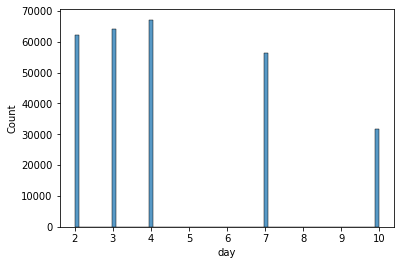

In [13]:
sns.histplot(input.metadata["day"])

In [14]:
input.metadata["donor"].value_counts()

31800    74963
13176    73211
32606    72359
27678    60995
Name: donor, dtype: int64

In [15]:
input.metadata["cell_type"].value_counts()

HSC       77535
hidden    55935
NeuP      42979
EryP      41479
MasP      34827
MkP       24021
MoP        3883
BP          869
Name: cell_type, dtype: int64

<AxesSubplot:xlabel='cell_type', ylabel='Count'>

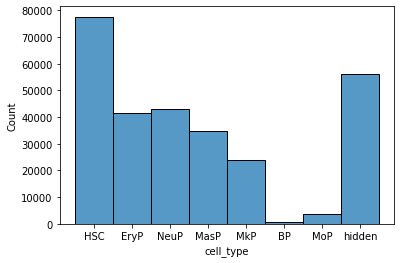

In [16]:
sns.histplot(input.metadata["cell_type"])

In [17]:
input.metadata["technology"].value_counts()

multiome    161877
citeseq     119651
Name: technology, dtype: int64

## Evaluation IDs



In [18]:
input.evaluation_ids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65744180 entries, 0 to 65744179
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   row_id   int32 
 1   cell_id  object
 2   gene_id  object
dtypes: int32(1), object(2)
memory usage: 1.2+ GB


In [19]:
input.evaluation_ids.head()

,row_id,cell_id,gene_id
0,0,c2150f55becb,CD86
1,1,c2150f55becb,CD274
2,2,c2150f55becb,CD270
3,3,c2150f55becb,CD155
4,4,c2150f55becb,CD112


In [20]:
input.evaluation_ids.tail()

,row_id,cell_id,gene_id
65744175,65744175,2c53aa67933d,ENSG00000134419
65744176,65744176,2c53aa67933d,ENSG00000186862
65744177,65744177,2c53aa67933d,ENSG00000170959
65744178,65744178,2c53aa67933d,ENSG00000107874
65744179,65744179,2c53aa67933d,ENSG00000166012


In [21]:
input.evaluation_ids.describe()

,row_id
count,6.574418e+07
mean,3.287209e+07
std,1.897871e+07
min,0.000000e+00
25%,1.643604e+07
50%,3.287209e+07
75%,4.930813e+07
max,6.574418e+07


In [22]:
df_stats(input.evaluation_ids)

,カラム名,ユニーク値数,最頻値,最頻値の出現回数,最頻値の割合,欠損値の数,欠損値の割合,タイプ
0,row_id,65744180,0,1,0.000002,0,0.0,int32
1,cell_id,65443,2c53aa67933d,3512,0.005342,0,0.0,object
2,gene_id,23558,CD86,48663,0.074019,0,0.0,object


In [36]:
gene_ids = input.evaluation_ids["gene_id"].unique()

In [37]:
gene_ids

array(['CD86', 'CD274', 'CD270', ..., 'ENSG00000188800',
       'ENSG00000114650', 'ENSG00000125686'], dtype=object)

In [38]:
len(gene_ids)

23558

In [49]:
cell_ids = input.evaluation_ids["cell_id"].unique()

In [50]:
cell_ids

array(['c2150f55becb', '65b7edf8a4da', 'c1b26cb1057b', ...,
       '0ddfc0ba4098', '31b078475100', '2c53aa67933d'], dtype=object)

In [51]:
len(cell_ids)

65443

## Sample Submission




In [23]:
input.sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65744180 entries, 0 to 65744179
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   row_id  int32  
 1   target  float32
dtypes: float32(1), int32(1)
memory usage: 501.6 MB


In [24]:
input.sample_submission.head()

,row_id,target
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


## CITE data

In [25]:
input.train_cite_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70988 entries, 45006fe3e4c8 to c91b6b2ccd3d
Columns: 22050 entries, ENSG00000121410_A1BG to ENSG00000074755_ZZEF1
dtypes: float32(22050)
memory usage: 5.8+ GB


In [27]:
input.train_cite_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70988 entries, 45006fe3e4c8 to c91b6b2ccd3d
Columns: 140 entries, CD86 to CD224
dtypes: float32(140)
memory usage: 38.5+ MB


In [34]:
input.train_cite_targets.columns

Index(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52',
       ...
       'CD94', 'CD162', 'CD85j', 'CD23', 'CD328', 'HLA-E', 'CD82', 'CD101',
       'CD88', 'CD224'],
      dtype='object', length=140)

In [30]:
input.test_cite_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48663 entries, c2150f55becb to ad5a949989b2
Columns: 22050 entries, ENSG00000121410_A1BG to ENSG00000074755_ZZEF1
dtypes: float32(22050)
memory usage: 4.0+ GB


In [35]:
input.test_cite_inputs.columns

Index(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', 'ENSG00000245105_A2M-AS1',
       'ENSG00000166535_A2ML1', 'ENSG00000128274_A4GALT',
       'ENSG00000094914_AAAS', 'ENSG00000081760_AACS', 'ENSG00000109576_AADAT',
       'ENSG00000103591_AAGAB',
       ...
       'ENSG00000153975_ZUP1', 'ENSG00000086827_ZW10',
       'ENSG00000174442_ZWILCH', 'ENSG00000122952_ZWINT',
       'ENSG00000198205_ZXDA', 'ENSG00000198455_ZXDB', 'ENSG00000070476_ZXDC',
       'ENSG00000162378_ZYG11B', 'ENSG00000159840_ZYX',
       'ENSG00000074755_ZZEF1'],
      dtype='object', length=22050)

In [47]:
input.test_cite_inputs.index

Index(['c2150f55becb', '65b7edf8a4da', 'c1b26cb1057b', '917168fa6f83',
       '2b29feeca86d', '0fd801488185', '526647a698f8', 'ab8f207a3dec',
       '57f730249c87', '08df3dcce25c',
       ...
       '87644788920d', '4b759a227f82', '294b63574ccd', 'd4876939c837',
       '0b0479644c65', 'a9b4d99f1f50', '0e2c1d0782af', 'a3cbc5aa0ec3',
       '75b350243add', 'ad5a949989b2'],
      dtype='object', name='cell_id', length=48663)

## Multiome data

In [28]:
input.train_multi_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105942 entries, 56390cf1b95e to 193992d571a5
Columns: 228942 entries, GL000194.1:114519-115365 to chrY:7873814-7874709
dtypes: float32(228942)
memory usage: 90.4+ GB


In [29]:
input.train_multi_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105942 entries, 56390cf1b95e to 193992d571a5
Columns: 23418 entries, ENSG00000121410 to ENSG00000074755
dtypes: float32(23418)
memory usage: 9.2+ GB


In [33]:
input.train_multi_targets.columns

Index(['ENSG00000121410', 'ENSG00000268895', 'ENSG00000175899',
       'ENSG00000245105', 'ENSG00000166535', 'ENSG00000256661',
       'ENSG00000184389', 'ENSG00000128274', 'ENSG00000094914',
       'ENSG00000081760',
       ...
       'ENSG00000086827', 'ENSG00000174442', 'ENSG00000122952',
       'ENSG00000198205', 'ENSG00000198455', 'ENSG00000070476',
       'ENSG00000203995', 'ENSG00000162378', 'ENSG00000159840',
       'ENSG00000074755'],
      dtype='object', length=23418)

In [31]:
input.test_multi_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55935 entries, 458c2ae2c9b1 to b847ba21f59f
Columns: 228942 entries, GL000194.1:114519-115365 to chrY:7873814-7874709
dtypes: float32(228942)
memory usage: 47.7+ GB


In [32]:
input.test_multi_inputs.columns

Index(['GL000194.1:114519-115365', 'GL000194.1:55758-56597',
       'GL000194.1:58217-58957', 'GL000194.1:59535-60431',
       'GL000195.1:119766-120427', 'GL000195.1:120736-121603',
       'GL000195.1:137437-138345', 'GL000195.1:15901-16653',
       'GL000195.1:22357-23209', 'GL000195.1:23751-24619',
       ...
       'chrY:7722278-7723128', 'chrY:7723971-7724880', 'chrY:7729854-7730772',
       'chrY:7731785-7732664', 'chrY:7810142-7811040', 'chrY:7814107-7815018',
       'chrY:7818751-7819626', 'chrY:7836768-7837671', 'chrY:7869454-7870371',
       'chrY:7873814-7874709'],
      dtype='object', length=228942)

In [48]:
input.test_multi_inputs.index

Index(['458c2ae2c9b1', '01a0659b0710', '028a8bc3f2ba', '7ec0ca8bb863',
       'caa0b0022cdc', 'e0bc46450106', '632ae0df4dcd', '852044b3a2c9',
       'fc09f456158f', '6e3df813cfcf',
       ...
       '9be27f116147', 'f4a9f986da93', '6f5eced93605', 'e04bd990dfaa',
       'd8b95b8379a0', '96a60b026659', 'd493e546991e', '05666c99aa48',
       '121f946642b5', 'b847ba21f59f'],
      dtype='object', name='cell_id', length=55935)

## EDA

In [46]:
# Train と Test の target の差分がないかチェック

len(input.train_cite_targets.columns), len(input.train_multi_targets.columns), len(gene_ids)

(140, 23418, 23558)

In [52]:
# Test の cell_id の数をチェック
# → テストデータのすべてのIDが evaluation_ids にあるわけではないようだ。

len(input.test_cite_inputs.index), len(input.test_multi_inputs.index), len(cell_ids)

(48663, 55935, 65443)

In [54]:
len(input.test_cite_inputs.index) + len(input.test_multi_inputs.index)

104598

In [53]:
len(set(list(input.test_cite_inputs.index) + list(input.test_multi_inputs.index)))

104598

## Preprocess



## Dataset

In [ ]:
# ds = BaseDataset(c, input.metadata)
ds = BaseDataset(c, pd.concat([input.metadata, input.evaluation_ids]))

for i in range(1):
    image, label = ds[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

In [ ]:
# ds = BaseDataset(c, input.metadata, transform=get_transforms(c, "light"))
ds = BaseDataset(c, pd.concat([input.metadata, input.evaluation_ids]), transform=get_transforms(c, "light"))

for i in range(1):
    image, label = ds[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

## Model

In [ ]:
model = ImageBaseModel(c)
model

In [ ]:
# ds = BaseDataset(c, input.metadata, transform=get_transforms(c, "light"))
ds = BaseDataset(c, pd.concat([input.metadata, input.evaluation_ids]), transform=get_transforms(c, "light"))
loader = DataLoader(ds, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in loader:
    output = model(image)
    print(output)
    break